In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import xgboost
from scipy import stats

from statsmodels.tsa.stattools import adfuller

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
import random
import string
import bisect
import collections

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import itertools

/Users/dkurra/miniconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Using TensorFlow backend.


Load the training dataset

In [2]:
training_dataset = pd.read_csv('./training.tsv', sep='\t', names=['user_id', 'date', 'action'])

In [3]:
training_dataset['date'] = pd.to_datetime(training_dataset["date"])
training_dataset.sort_values(by=['date'])
grouped = training_dataset.groupby(['user_id'])
user_action_date = grouped.agg({'action': list, 'date': list}).reset_index()

In [121]:
training_dataset.head()

,user_id,date,action
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


## Dataset Statictis

### Number of Purchasers

In [163]:
purchasers_user_action_date = user_action_date[user_action_date.action.apply(lambda x: 'Purchase' in x)]

In [164]:
purchasers_count = purchasers_user_action_date.shape[0]
print('Number of purchasers:', purchasers_count)

Number of purchasers: 103991


### Number of non purchasers

In [165]:
non_purchasers_user_action_date = user_action_date[user_action_date.action.apply(lambda x: not 'Purchase' in x)]
non_purchasers_count = non_purchasers_user_action_date.shape[0]

In [166]:
print('Number of Non purchasers:', non_purchasers_count)

Number of Non purchasers: 237577


In [167]:
rate = (purchasers_count/(non_purchasers_count + purchasers_count))*100
print('%.2f%% of users purchased atleast once' % rate)

30.45% of users purchased atleast once


### Number of users

In [168]:
print('Number of users', non_purchasers_count + purchasers_count)

Number of users 341568


### Number of Actions

In [169]:
print('Number of actions', training_dataset.shape[0])

Number of actions 4918677


### Time duration

In [170]:
print('Total number of days in which actions were recorded:',(training_dataset.date.max() - training_dataset.date.min()).days)

Total number of days in which actions were recorded: 670


### Years in which purchases were made

In [171]:
training_dataset.date.apply(lambda x: x.year).unique()

array([2013, 2014, 2015])

All the actions were recorded during 2013, 2014, 2015

#### Helper functions to preprocess data

In [15]:
# groups users and zips the (action, date)
# params: user_id, date, action
# returns [user_id, actions]
def zip_actions_date(row):
    actions = row['action']
    dates = row['date']
    
    return [row['user_id'], list(zip(actions, dates))]

In [16]:
def split_date_action(row):
    actions_date = row['actions']
    size = len(actions_date)
    idx_list = [idx + 1 for idx, val in enumerate(actions_date) if val[0] == 'Purchase']
    res =  [[row['user_id'], actions_date[i: j]] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))]
    
    return res

In [17]:
# delete any rows or records which has only action and which is purchase
def delete_purchase_tails(row):
    actions_date = row['actions']
    size = len(actions_date)
    res = [idx for idx, val in enumerate(actions_date) if val[0] == 'Purchase']
    return not len(res) == 0

In [18]:
# deletes any actions that occured after purchase for one time purchasers
# As we are interested only actions that occured before purchase
def delete_beyond_purchase_actions(row):
    actions_date = row['actions']
    size = len(actions_date)
    res = max(idx for idx, val in enumerate(actions_date) if val[0] == 'Purchase') 
    res =  [[row['user_id'], actions_date[0: res+1]]]
    return res

In [19]:
def more_than_one_action(row):
    actions_date = row['actions']
    size = len(actions_date)
    return  (size) > 1

In [20]:
# during analysis, actions occurence are counted as how far the action 
def day_prior_purchase(row):
    actions_date = row['actions']
    purchase_date = row['actions'][-1][1]
    res = []
    for action in actions_date:
        res.append((purchase_date - action[1]).days)
    
    actions_list = [action[0] for action in actions_date]
        
    row['actions'] = list(zip(actions_list, res))
    return row

###Number of days active in last seven day

In [21]:
def number_of_day_active_before_purchase(row):
    actions_date = row['actions']
    days = [action[1] for action in actions_date]
    days.reverse()
    return bisect.bisect_left(days, 7)

In [22]:
def number_of_actions_on_the_last_day(row):
    actions_date = row['actions']
    days = [action[1] for action in actions_date]
    return days.count(0)

In [23]:
def actions_count(row, target):
    actions_date = row['actions']
    actions = [action[0] for action in actions_date]
    return actions.count(target)

In [24]:
def is_single_purchase(action_date_list):    
    actions = [action_date[0] for action_date in action_date_list]
    return actions.count('Purchase') == 1

def is_multiple_purchase(action_date_list):    
    actions = [action_date[0] for action_date in action_date_list]
    return actions.count('Purchase') > 1

def get_one_time_purchasers(df):
    return df[df.actions.apply(is_single_purchase)]

def get_mutliple_purchasers(df):
    return df[df.actions.apply(is_multiple_purchase)]

def split_multiple_purchases_into_single_purchase(df):
    df = df.apply(split_date_action, axis = 1)
    merged = list(itertools.chain.from_iterable(df.values.tolist()))
    
    return pd.DataFrame(merged, columns =['user_id', 'actions'])

def preprocessed_purchasers(df):
    df = df[df.apply(delete_purchase_tails, axis = 1)]
    df_2 = df.apply(delete_beyond_purchase_actions, axis = 1)
    merged = list(itertools.chain.from_iterable(df_2.values.tolist()))
    return pd.DataFrame(merged, columns =['user_id', 'actions'])


def add_action_type_features(df):
    df.loc[:, 'EmailOpen_cnt'] = df.apply(lambda x: actions_count(x, 'EmailOpen'), axis=1)
    df.loc[:, 'FormSubmit_cnt'] = df.apply(lambda x: actions_count(x, 'FormSubmit'), axis=1)
    df.loc[:, 'EmailClickthrough_cnt'] = df.apply(lambda x: actions_count(x, 'EmailClickthrough'), axis=1)
    df.loc[:, 'CustomerSupport_cnt'] = df.apply(lambda x: actions_count(x, 'CustomerSupport'), axis=1)
    df.loc[:, 'PageView_cnt'] = df.apply(lambda x: actions_count(x, 'PageView'), axis=1)
    df.loc[:, 'WebVisit_cnt'] = df.apply(lambda x: actions_count(x, 'WebVisit'), axis=1)

# returns the negative offset of when the purchase has happened
def day_prior_purchase(row):
    actions_date = row['actions']
    purchase_date = row['actions'][-1][1]
    res = []
    for action in actions_date:
        res.append((purchase_date - action[1]).days)
    
    actions_list = [action[0] for action in actions_date]
        
    row['actions'] = list(zip(actions_list, res))
    return row

# For analysis we consider only actions that occured 60days prior to purchase
def purchase_within_60days(row):
    actions_date = row['actions']
    purchase_date = row['actions'][-1][1]
    action_start_date = row['actions'][0][1]
    return (action_start_date - purchase_date) <= 60
    
def add_temporal_feature(df):
    df = df.apply(day_prior_purchase, axis = 1)
    return df[df.apply(purchase_within_60days, axis = 1)]

def add_activity_related_feature(df):
    df['active_days'] = df.apply(number_of_day_active_before_purchase, axis=1)
    df['last_day_activity'] = df.apply(number_of_actions_on_the_last_day, axis=1)
    

In [25]:
def get_single_multiple_purchasers(dataset):
    # convert date to pd date format
    dataset['date'] = pd.to_datetime(dataset["date"])
    dataset.sort_values(by=['date'])
    # group actions by user
    grouped = dataset.groupby(['user_id'])
    # data structured as user_id, list of actions, list of dates
    user_action_date = grouped.agg({'action': list, 'date': list}).reset_index()
    
    # get all users with purchase
    purchasers_user_action_date = user_action_date[user_action_date.action.apply(lambda x: 'Purchase' in x)]
    
    # zip actions and dates, format, user_id, list[list[action, day]]
    purchasers_zip_actions_date = purchasers_user_action_date.apply(zip_actions_date, axis = 1)
    purchasers_user_action_date = pd.DataFrame(purchasers_zip_actions_date.values.tolist(), columns =['user_id', 'actions']) 
    # get user who purchased only once
    one_time_purchasers = get_one_time_purchasers(purchasers_user_action_date)
    # get users who purchased more than once
    multiple_purchasers = get_mutliple_purchasers(purchasers_user_action_date)
    
    return one_time_purchasers, multiple_purchasers

In [26]:
def users_with_no_purchases(dataset):
    dataset['date'] = pd.to_datetime(dataset["date"])
    dataset.sort_values(by=['date'])
    grouped = dataset.groupby(['user_id'])
    user_action_date = grouped.agg({'action': list, 'date': list}).reset_index()
    
    non_purchasers_user_action_date = user_action_date[user_action_date.action.apply(lambda x: not 'Purchase' in x)]
    non_purchasers_zip_actions_date = non_purchasers_user_action_date.apply(zip_actions_date, axis = 1)
    non_purchasers_zip_actions_date = pd.DataFrame(non_purchasers_zip_actions_date.values.tolist(), columns =['user_id', 'actions']) 
    
    return non_purchasers_zip_actions_date
    

In [27]:
def preprocess_dataset(dataset):
    one_time_purchasers, multiple_purchasers = get_single_multiple_purchasers(dataset)
    multiple_purchasers_split = split_multiple_purchases_into_single_purchase(multiple_purchasers)
    purchases_sliced = pd.concat([one_time_purchasers, multiple_purchasers_split])
    purchases = preprocessed_purchasers(purchases_sliced)
    

    non_purchasers = users_with_no_purchases(dataset)
    
    # Temporal feature, add context of how many negative offsets the actions happened before actual purchase is being made
    purchases_days_prior_limit_60 = add_temporal_feature(purchases)
    non_purchases_days_prior_limit_60 = add_temporal_feature(non_purchasers)

    #add acivity features
    add_activity_related_feature(purchases_days_prior_limit_60)
    add_activity_related_feature(non_purchases_days_prior_limit_60)
    
    non_purchases_days_prior_limit_60[non_purchases_days_prior_limit_60.last_day_activity > 10]
    
    add_action_type_features(purchases_days_prior_limit_60)
    add_action_type_features(non_purchases_days_prior_limit_60)
    return purchases_days_prior_limit_60, non_purchases_days_prior_limit_60

### Users with no purchases

In [28]:
non_purchasers = users_with_no_purchases(training_dataset)

In [29]:
print('Number of users NO purchases:', non_purchasers.shape[0])

Number of users NO purchases: 237577


### Users with exactly one purchase

In [30]:
one_time_purchasers, multiple_purchasers = get_single_multiple_purchasers(training_dataset)

In [31]:
print('Number of users with single purchase:', one_time_purchasers.shape[0])

Number of users with single purchase: 49635


### Users with more than one purchase

In [32]:
print('Number of users with multiple purchases:', multiple_purchasers.shape[0])

Number of users with multiple purchases: 54356


In [33]:
multiple_purchasers.head()

,user_id,actions
0,0000ecf58c94668,"[(Purchase, 2013-10-30 00:00:00), (Purchase, 2..."
5,000473d9fd60802,"[(Purchase, 2013-07-10 00:00:00), (Purchase, 2..."
6,0005753b743e7a4,"[(Purchase, 2013-12-12 00:00:00), (Purchase, 2..."
8,000711b04f50795,"[(EmailOpen, 2013-07-01 00:00:00), (EmailOpen,..."
9,00074a7bf0072e1,"[(EmailOpen, 2013-07-02 00:00:00), (Purchase, ..."


In [34]:
all_purchasers = pd.concat([one_time_purchasers, multiple_purchasers])
all_purchasers.head()

,user_id,actions
1,000198d39a568cf,"[(Purchase, 2014-01-09 00:00:00), (CustomerSup..."
2,00022618457fcf2,"[(Purchase, 2013-07-31 00:00:00), (CustomerSup..."
3,000256826de4432,"[(Purchase, 2014-10-06 00:00:00), (CustomerSup..."
4,000448571a815df,"[(Purchase, 2014-07-08 00:00:00), (CustomerSup..."
7,00068220c7bfc33,"[(Purchase, 2014-03-14 00:00:00), (CustomerSup..."


In [35]:
rate = (multiple_purchasers.shape[0]/all_purchasers.shape[0])*100
print('%.2f%% of purchasers make more than one purchase' % rate)

52.27% of purchasers make more than one purchase


### Purchase Frequency

In [36]:
def count_purchases(action):
    res = 0
    for each_action in action:
        res += (each_action[0] == 'Purchase')
    return res
user_purchase = all_purchasers.actions.apply(count_purchases)

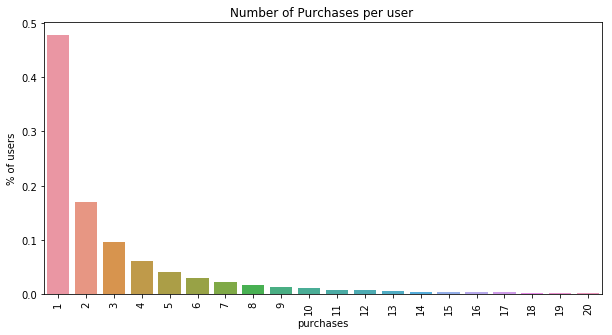

In [37]:
plt.figure(figsize=(10,5))
sns.barplot(user_purchase.value_counts(normalize=True)[:20].index, user_purchase.value_counts(normalize=True)[:20].values)
plt.title('purcases count vs users')
plt.ylabel('% of purchased users')
plt.xlabel('number of purchases')
plt.xticks( rotation='vertical')
plt.show()

Purchases follow heavy right skew with many users making one purchase. 

In [38]:
user_purchase.describe()

count    103991.000000
mean          3.798704
std           8.387857
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         352.000000
Name: actions, dtype: float64

- 47% of the users likely to make only one purchase
- Average of around 3
- A user placed 352 orders (woh!)

### Number of active days wrt to purchasers and non-purchasers


In [39]:
def count_active_days(action):
    res = []
    for each_action in action:
        res.append(each_action[1])
    date_series = pd.Series(res)
    return pd.to_datetime(date_series).nunique()
purchasers_active_days = all_purchasers.actions.apply(count_active_days)
non_purchasers_active_days = non_purchasers.actions.apply(count_active_days)

In [40]:
purchasers_active_days_counts = purchasers_active_days.value_counts()

In [41]:
purchasers_active_days_counts

2      37322
3      13200
4       7552
5       5029
6       3602
       ...  
569        1
464        1
528        1
424        1
511        1
Name: actions, Length: 483, dtype: int64

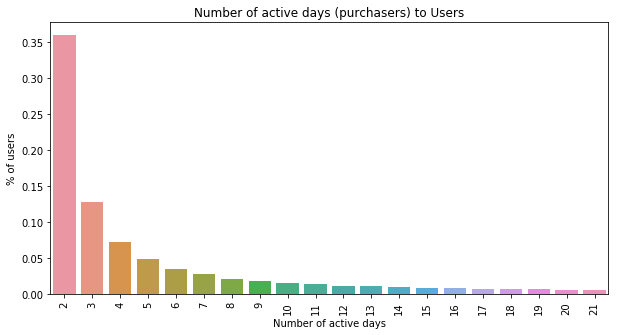

In [173]:
plt.figure(figsize=(10,5))
sns.barplot(purchasers_active_days.value_counts(normalize=True)[:20,].index, purchasers_active_days.value_counts(normalize=True)[:20,].values)
plt.title('Number of active days (purchasers) to Users')
plt.ylabel('% of users')
plt.xlabel('Number of active days')
plt.xticks( rotation='vertical')
plt.show()

Purchasers activity has varied range starting for 2 days of activity to 511 days of activity

In [174]:
non_purchasers_active_days.value_counts()

1      67987
2      34605
3      20813
4      14886
5      11635
       ...  
279        1
436        1
308        1
335        1
255        1
Name: actions, Length: 326, dtype: int64

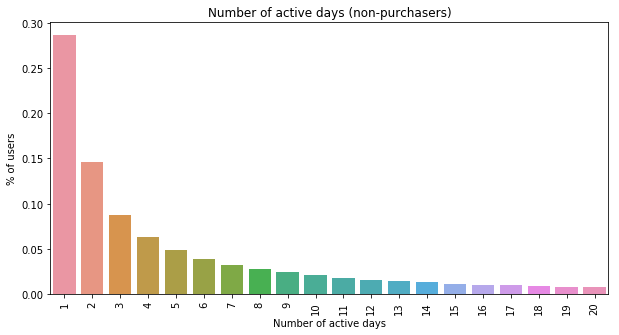

In [175]:
plt.figure(figsize=(10,5))
sns.barplot(non_purchasers_active_days.value_counts(normalize=True)[:20,].index, non_purchasers_active_days.value_counts(normalize=True)[:20,].values)
plt.title('Number of active days (non-purchasers)')
plt.ylabel('% of users')
plt.xlabel('Number of active days')
plt.xticks( rotation='vertical')
plt.show()


- Non Purchasers activity has varied range starting for 2 days of activity to 255 days of activity

### How actions vary for purchasers and non purchasers

In [176]:
def count_actions(action):
    return len(action)
purchasers_count_actions = all_purchasers.actions.apply(count_actions)
non_purchasers_count_actions = non_purchasers.actions.apply(count_actions)

In [177]:
purchasers_count_actions.value_counts()

2       37303
3       12862
4        7277
5        4864
6        3434
        ...  
703         1
2718        1
671         1
416         1
607         1
Name: actions, Length: 793, dtype: int64

In [178]:
non_purchasers_count_actions.value_counts()

1     54558
2     18860
3     10230
4      4260
5      2997
6      1205
7       713
8       423
9       278
10      207
11      151
12       99
13       80
14       54
16       45
15       42
17       22
18       17
20       15
19       12
28        9
21        9
22        8
23        8
25        5
27        5
26        4
29        4
31        3
24        3
30        2
33        2
57        1
46        1
54        1
51        1
50        1
47        1
35        1
43        1
41        1
38        1
37        1
32        1
60        1
Name: actions, dtype: int64

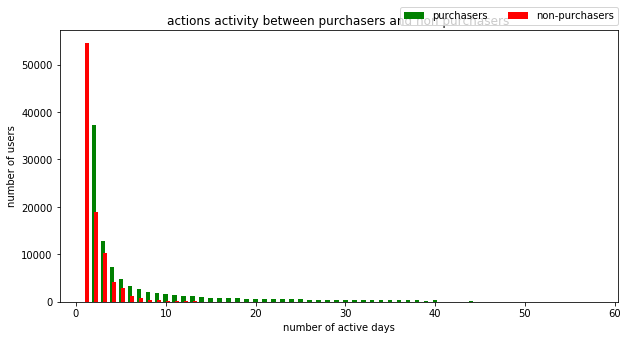

In [188]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
w = 0.5

ax.set_xlabel('number of active days')
ax.set_ylabel('number of users')


ax.set_title('actions activity between purchasers and non purchasers')
purchasers = ax.bar(purchasers_count_actions.value_counts()[:40].index, purchasers_count_actions.value_counts()[:40].values, width=w, color='g', align='center')
non_purchasers = ax.bar(non_purchasers_count_actions.value_counts()[:40].index + w/2, non_purchasers_count_actions.value_counts()[:40].values, width=w, color='r', align='center')
ax.legend((purchasers[0], non_purchasers[0]), ('purchasers', 'non-purchasers'),loc="lower right", bbox_to_anchor=(1., 1.02) , borderaxespad=0., ncol=2)
plt.show()

Non purchasers seems to do alot more exploration than purchasers but more importantly purchasers seems to do more actions right before the purchase. which is included as feature (temporal) in analysis

### Day of the week on which purchase was made


In [189]:
all_purchasers.head()

,user_id,actions
1,000198d39a568cf,"[(Purchase, 2014-01-09 00:00:00), (CustomerSup..."
2,00022618457fcf2,"[(Purchase, 2013-07-31 00:00:00), (CustomerSup..."
3,000256826de4432,"[(Purchase, 2014-10-06 00:00:00), (CustomerSup..."
4,000448571a815df,"[(Purchase, 2014-07-08 00:00:00), (CustomerSup..."
7,00068220c7bfc33,"[(Purchase, 2014-03-14 00:00:00), (CustomerSup..."


In [190]:
def get_purchase_day(action):
    for each_action in action:
        if each_action[0] == 'Purchase':
            return pd.to_datetime(each_action[1]).dayofweek

prchase_day_counts = all_purchasers.actions.apply(get_purchase_day).value_counts()

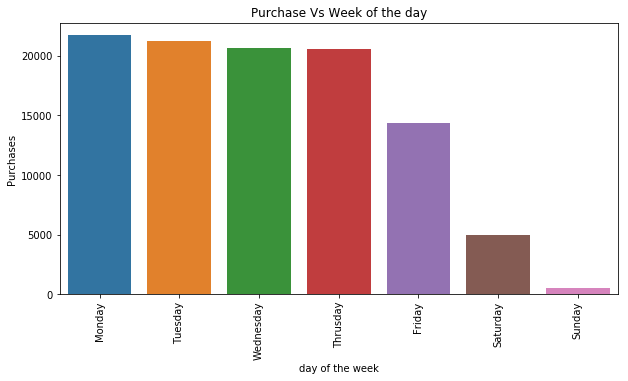

In [192]:

plt.figure(figsize=(10,5))
sns.barplot(['Monday', 'Tuesday', 'Wednesday', 'Thrusday','Friday', 'Saturday', 'Sunday'], prchase_day_counts.values)
plt.title('Purchase Vs Week of the day')
plt.ylabel('Purchases')
plt.xlabel('day of the week')
plt.xticks( rotation='vertical')
plt.show()

- Most of the weekdays have similar purchase trend
- Weekend have a less sales when compared to weekdays

### Modeling Intent

- Activity based features: From the EDA it is understood that activity overall between purchasers and non-purchases doesnot vary much. However the last 3 to 7 days before the purchase seems to give indication who would endup purchasing. There seems to higher activity among purchasers in last few days before purchase. Modeling as feature `active_days`

- Another feature is how activity user is on a day, would indicate purchase intent. Purchasers seems to super active on the day of purchase `last_day_activity`

- Content related: what actions a user is doing could indicate willingness to buy a product. Modeled in as `'EmailOpen_cnt', 'FormSubmit_cnt', 'EmailClickthrough_cnt','CustomerSupport_cnt', 'PageView_cnt', 'WebVisit_cnt'`

- Other features that could be added but not implemented: actions done t-1, t-2, t-3 days prior to purchase

In [55]:
training_dataset = pd.read_csv('./training.tsv', sep='\t', names=['user_id', 'date', 'action'])

In [56]:
purchasers, non_purchasers = preprocess_dataset(training_dataset)

In [126]:
non_purchasers.head()

,user_id,actions,active_days,last_day_activity,EmailOpen_cnt,FormSubmit_cnt,EmailClickthrough_cnt,CustomerSupport_cnt,PageView_cnt,WebVisit_cnt
0,00002acbe042d69,"[(EmailOpen, 32), (FormSubmit, 32), (EmailOpen...",1,1,9,1,0,0,0,0
2,00012205dd4613b,"[(EmailOpen, 28), (EmailOpen, 0)]",1,1,2,0,0,0,0,0
3,0001b315b991cf0,"[(EmailOpen, 0)]",1,1,1,0,0,0,0,0
4,000269150971d08,"[(EmailOpen, 38), (EmailOpen, 32), (EmailOpen,...",1,1,3,0,0,0,0,0
6,0002f5c71a86aa3,"[(EmailOpen, 50), (EmailOpen, 0)]",1,1,2,0,0,0,0,0


In [57]:
 def split_features_labels(purchases_days_prior_limit_60, non_purchases_days_prior_limit_60):
    purchases_training = purchases_days_prior_limit_60[['active_days', 'last_day_activity',
   'EmailOpen_cnt', 'FormSubmit_cnt', 'EmailClickthrough_cnt',
   'CustomerSupport_cnt', 'PageView_cnt', 'WebVisit_cnt']]

    non_purchases_training = non_purchases_days_prior_limit_60[['active_days', 'last_day_activity',
           'EmailOpen_cnt', 'FormSubmit_cnt', 'EmailClickthrough_cnt',
           'CustomerSupport_cnt', 'PageView_cnt', 'WebVisit_cnt']]

    positive_labels = (np.array([1]*purchases_training.shape[0]).T).tolist()
    purchases_training['label'] = positive_labels

    non_purchases_training['label'] = (np.array([0]*non_purchases_training.shape[0]).T).tolist()

    proccessed_dataset = pd.concat([purchases_training, non_purchases_training])
    labels = np.array(proccessed_dataset['label'])
    features = np.array(proccessed_dataset[['active_days', 'last_day_activity', 'EmailOpen_cnt', 'FormSubmit_cnt',
           'EmailClickthrough_cnt', 'CustomerSupport_cnt', 'PageView_cnt',
           'WebVisit_cnt']])
    return features, labels, proccessed_dataset

In [58]:
training_features, training_labels, proccessed_dataset = split_features_labels(purchasers, non_purchasers)

/Users/dkurra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/dkurra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [59]:
purchasers.head()

,user_id,actions,active_days,last_day_activity,EmailOpen_cnt,FormSubmit_cnt,EmailClickthrough_cnt,CustomerSupport_cnt,PageView_cnt,WebVisit_cnt
0,000198d39a568cf,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
1,00022618457fcf2,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
2,000256826de4432,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
3,000448571a815df,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
4,00068220c7bfc33,"[(Purchase, 0)]",1,1,0,0,0,0,0,0


In [60]:
proccessed_dataset.columns

Index(['active_days', 'last_day_activity', 'EmailOpen_cnt', 'FormSubmit_cnt',
       'EmailClickthrough_cnt', 'CustomerSupport_cnt', 'PageView_cnt',
       'WebVisit_cnt', 'label'],
      dtype='object')

In [61]:
proccessed_dataset = proccessed_dataset.sample(frac=1).reset_index(drop=True)

In [62]:
train_X_df = proccessed_dataset[['active_days', 'last_day_activity', 'EmailOpen_cnt', 'FormSubmit_cnt',
       'EmailClickthrough_cnt', 'CustomerSupport_cnt', 'PageView_cnt',
       'WebVisit_cnt']]

train_y_df = proccessed_dataset[['label']]

### Final Features used for Modeling

- 'active_days'
- 'last_day_activity'
- 'EmailOpen_cnt'
- 'FormSubmit_cnt',
- 'EmailClickthrough_cnt'
- 'CustomerSupport_cnt'
- 'PageView_cnt'
- 'WebVisit_cnt'

### User actions between purchasers and non purchasers

In [63]:
purchasers.head()

,user_id,actions,active_days,last_day_activity,EmailOpen_cnt,FormSubmit_cnt,EmailClickthrough_cnt,CustomerSupport_cnt,PageView_cnt,WebVisit_cnt
0,000198d39a568cf,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
1,00022618457fcf2,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
2,000256826de4432,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
3,000448571a815df,"[(Purchase, 0)]",1,1,0,0,0,0,0,0
4,00068220c7bfc33,"[(Purchase, 0)]",1,1,0,0,0,0,0,0


In [131]:
actions = ['EmailOpen_cnt', 'FormSubmit_cnt','EmailClickthrough_cnt', 'PageView_cnt',
       'WebVisit_cnt']

purchases_actions_count = collections.defaultdict()
for a in actions:
    purchases_actions_count[a] = purchasers[a].sum()
    
non_purchases_actions_count = collections.defaultdict()   

for a in actions:
    non_purchases_actions_count[a] = non_purchasers[a].sum()


In [133]:
purchases_actions_count

defaultdict(None,
            {'EmailOpen_cnt': 347328,
             'FormSubmit_cnt': 30473,
             'EmailClickthrough_cnt': 48875,
             'PageView_cnt': 91003,
             'WebVisit_cnt': 90582})

In [134]:
p_index = list(purchases_actions_count.keys())
p_values = list(purchases_actions_count.values())

In [135]:
n_index = list(non_purchases_actions_count.keys())
n_values = list(non_purchases_actions_count.values())

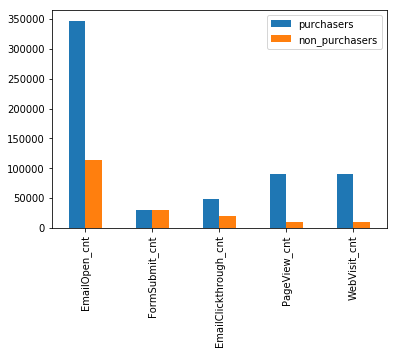

In [136]:
d = {
    'purchasers': purchases_actions_count,
    'non_purchasers': non_purchases_actions_count
}
pd.DataFrame(d).plot(kind='bar')
plt.show()

- Purchasers  have high content expoloration (PageView, Website visit, emailClickThrought, EmailOpen) than Non purchasers

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(training_features, training_labels, test_size = 0.25, random_state = 42)

### Test set

Load the testing data

In [71]:
test_dataset = pd.read_csv('./test.tsv', sep='\t', names=['user_id', 'date', 'action'])

In [72]:
def preprocess_dataset(dataset):
    dataset['date'] = pd.to_datetime(dataset["date"])
    dataset.sort_values(by=['date'])
    grouped = dataset.groupby(['user_id'])
    user_action_date = grouped.agg({'action': list, 'date': list}).reset_index()    
    non_purchasers_user_action_date = user_action_date[user_action_date.action.apply(lambda x: not 'Purchase' in x)]
    non_purchasers_zip_actions_date = non_purchasers_user_action_date.apply(zip_actions_date, axis = 1)
    non_purchasers_zip_actions_date = pd.DataFrame(non_purchasers_zip_actions_date.values.tolist(), columns =['user_id', 'actions']) 
    non_purchasers = non_purchasers_zip_actions_date
    
    # Temporal feature, all day related info
    non_purchases_days_prior_limit_60 = add_temporal_feature(non_purchasers)
    add_activity_related_feature(non_purchases_days_prior_limit_60)    
    non_purchases_days_prior_limit_60[non_purchases_days_prior_limit_60.last_day_activity > 10]
    add_action_type_features(non_purchases_days_prior_limit_60)
    return non_purchases_days_prior_limit_60

In [73]:
 def split_features_labels_test(test_records):
    test_records = test_records[['active_days', 'last_day_activity',
           'EmailOpen_cnt', 'FormSubmit_cnt', 'EmailClickthrough_cnt',
           'CustomerSupport_cnt', 'PageView_cnt', 'WebVisit_cnt']]


    features = np.array(test_records[['active_days', 'last_day_activity', 'EmailOpen_cnt', 'FormSubmit_cnt',
           'EmailClickthrough_cnt', 'CustomerSupport_cnt', 'PageView_cnt',
           'WebVisit_cnt']])
    return features, test_records

In [74]:
records = preprocess_dataset(test_dataset)

In [75]:
records.head()

,user_id,actions,active_days,last_day_activity,EmailOpen_cnt,FormSubmit_cnt,EmailClickthrough_cnt,CustomerSupport_cnt,PageView_cnt,WebVisit_cnt
1,000132f21724ee2,"[(EmailClickthrough, 0), (EmailOpen, 0)]",2,2,1,0,1,0,0,0
2,0001b315b991cf0,"[(EmailOpen, 55), (EmailOpen, 1), (EmailOpen, 0)]",2,1,3,0,0,0,0,0
3,000269150971d08,"[(EmailOpen, 51), (EmailOpen, 30), (EmailOpen,...",1,1,4,0,0,0,0,0
4,000297ba4fa5026,"[(EmailOpen, 54), (EmailOpen, 53), (EmailOpen,...",1,1,3,0,0,0,0,0
6,0003b304dd7cfae,"[(EmailOpen, 0)]",1,1,1,0,0,0,0,0


In [76]:
test_features, proccessed_test_dataset = split_features_labels_test(records)

In [77]:
proccessed_test_dataset = proccessed_test_dataset.sample(frac=1).reset_index(drop=True)

In [78]:
test_X_df = proccessed_test_dataset[['active_days', 'last_day_activity', 'EmailOpen_cnt', 'FormSubmit_cnt',
       'EmailClickthrough_cnt', 'CustomerSupport_cnt', 'PageView_cnt',
       'WebVisit_cnt']]

In [79]:
user_ids = records.user_id

### Modeling using  XG Boost


In [80]:
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)

In [83]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(train_X_df.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(train_y_df.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/dkurra/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 13.1min finished
/Users/dkurra/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 12.1min finished
/Users/dkurra/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 13.5min finished


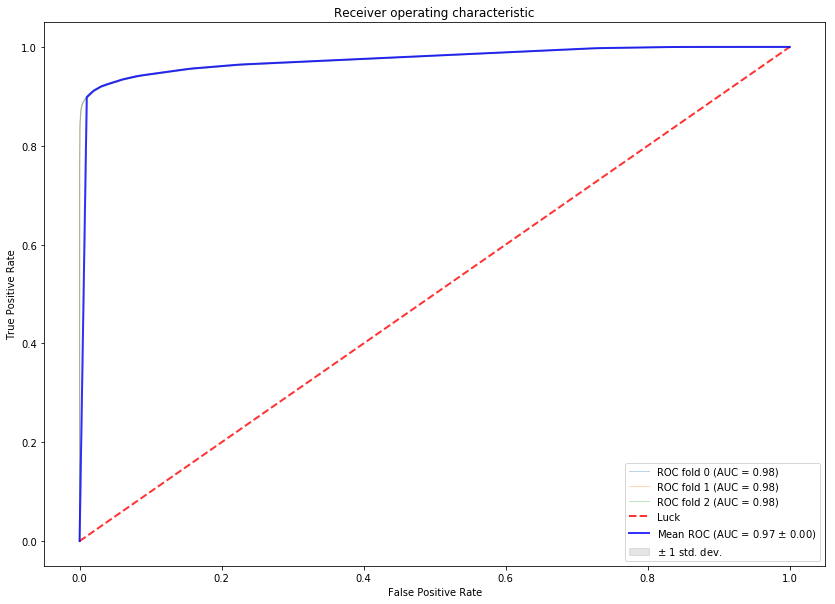

,AUC Train,AUC Test
0,0.977497,0.977430
1,0.977646,0.977130
2,0.978233,0.976741


In [87]:
clf_xgb = xgboost.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 3
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
results = np.zeros(len(train_X_df))
score = 0.0
for train_index, test_index in folds.split(train_X_df):
    X_train, X_test = train_X_df.iloc[train_index,:], train_X_df.iloc[test_index,:]
    y_train, y_test = train_y_df.iloc[train_index].values.ravel(), train_y_df.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)
    _, _, auc_score_train = compute_roc_auc(train_index)
    fpr, tpr, auc_score = compute_roc_auc(test_index)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += f1_score(y_test, results[test_index])
score /= numFolds

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [197]:
print('%.2f%% Average score using XGBoost' % (score*100))

95.86% Average score using XGBoost


### Feature importance

In [152]:
f = 'gain'
importances = clf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

In [153]:
importances

array([0.12134972, 0.08448373, 0.31720576, 0.31269085, 0.10717899,
       0.        , 0.02322705, 0.03386386], dtype=float32)

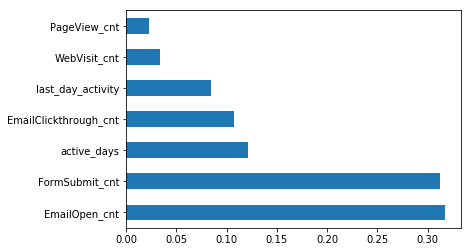

In [155]:
(pd.Series(clf.best_estimator_.feature_importances_, index=train_X_df.columns)
   .nlargest(7)
   .plot(kind='barh')) 

EmailOpen actions seems provide good estimator of purchaser behaviour, and least is with pageView action

### Getting purchase probable users on Test data

In [199]:
# predict on the trained model
test_user_predictions = clf.predict(test_X_df)

In [200]:
unique, counts = np.unique(test_user_predictions, return_counts=True)

In [201]:
prediction_counts =  dict(zip(unique, counts))

In [211]:
print('We have purchasers %d on Test data' % (prediction_counts[0]))
print('We have Non Purchasers %d on Test data' % (prediction_counts[1]))


We have purchasers 69450 on Test data
We have Non Purchasers 36811 on Test data


### Extracting high probable Purchasers

In [213]:
probs = clf.predict_proba(test_X_df)[:, 1]

In [214]:
user_id_prob = list(zip(user_ids, probs))

In [215]:
user_id_prob.sort(key = lambda x: -x[1])

In [216]:
top_1000_users = [user[0] for user in user_id_prob[:1000]]

In [218]:
test_probable_df = pd.DataFrame(top_1000_users, columns=["purchasers"])
test_probable_df.to_csv('probable_users.csv', index=False)